# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)



План работы

- провести анализ данных
- почистить данные
- заполнить пропуски в данных
- исследовать модели, предсказывающие цену машины по ее признакам, провксти анализ
- выбрать наилучшую по результатам анализа модель


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
SEED = 42

## Подготовка данных

In [4]:
df = pd.read_csv("/datasets/autos.csv")

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.shape

(354369, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
df.isna().mean() * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

### Анализ данных

1. Cтолбец `NumberOfPictures` состоит из нулевых значений. Скорее всего есть проблемв с выгрузкой данных. Поправить мы не можем, удалим его.
2. Столбцы `DateCrawled`, `LastSeen`, `DateCreated` имеют некоректный формат, поменяем его на `datetime`.
3. В столбце `RegistrationYear` присутствуют очевидно некорректные значения
4. В столбце `Power`  присутствуют очевидно некорректные значения
5. В столбце `Price`  присутствуют нулевые значения
6. В столбце `RegistrationMonth` присутствуют нулевые значения - это странно, видно что месяцев 12
7. В столбцах `VehicleType` `Gearbox` `Model` `FuelType` и `NotRepaired` присутствуют пропуски.

#### Проанализируем целевой признак

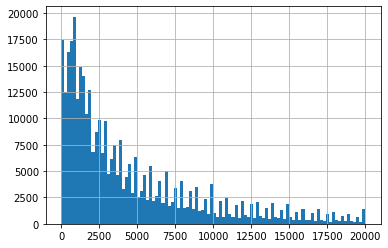

In [9]:
plt.hist(df.Price,
         bins=100
         )
plt.grid()
plt.show()

У нас виден всплеск в районе 0. 

Нулевая цена - это или некорректные данные, или подразумевается предложение продавца договориться "мимо" сервиса или человек не хочет тратится на цтилизацию и просит забрать неудобную собственность за "так" . 

Для нас эти данные не представляют ценности, и могут сместить оценку - удалим их


In [10]:
df.drop(df[df.Price < 1].index, inplace=True)

Посмотрим на нижнюю кванитиль

In [11]:
df.Price.quantile(0.05)

350.0

Можно предполжить, по ассортименту марок, что давнные собраны в Европе, судя по порядку цен - EC.

Я чуть-чуть поизучал рынок по форумам и сайтам типа [quora](https://www.quora.com/How-do-I-buy-a-used-car-for-300) и после этого склонен передвинуть нижнюю границу цены на 200, потому что историй и советов по покупке машины даже за 300 очень много. Около 200 - уже начинаются истории о "самовывозе" за свои деньги и покупке на запчасти

In [12]:
MIN_PRICE = 200

Кроме этого, люди которые ставят цены ниже 200 склонны не заполнять большое количество полей, что дополнительно снижает достоверность их данных

In [13]:
df[df.Price < MIN_PRICE].isna().mean() * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          35.426009
RegistrationYear      0.000000
Gearbox              26.905830
Power                 0.000000
Model                14.155456
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType             33.557549
Brand                 0.000000
NotRepaired          51.136024
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [14]:
df.drop(df[df.Price < MIN_PRICE].index, inplace=True)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

В данных остались машины только с адекватной ценой 👍
</div>

#### Признак NotRepaired - ремонтировалась ли машина

Предположим, что пропуски в столбце поямились из-ща того что при заполнении часть владельцев не битых машин прото игнорировали это поле - заполним признак соответствующе

In [15]:
df.NotRepaired = df.NotRepaired.fillna("yes")

#### Удалим NumberOfPictures как неинформативную

 Cтолбец `NumberOfPictures` состоит из нулевых значений. Скорее всего есть проблемв с выгрузкой данных. Поправить мы не можем, удалим его.

In [16]:
df.drop("NumberOfPictures", axis=1, inplace=True)

#### Поправим форматы дат и вычислим дату выгрузки и временной диапазон дат регистарции

Столбцы `DateCrawled`, `LastSeen`, `DateCreated` имеют некоректный формат, поменяем его на `datetime`.

In [17]:
df.DateCrawled = pd.to_datetime(df.DateCrawled)
df.LastSeen = pd.to_datetime(df.LastSeen)
df.DateCreated = pd.to_datetime(df.DateCreated)

Необходимо определить корректность года регистрации. Для этого попробуем определеить когда данные были выгружены. Попробуем определить это по времени последнего просмотра анкеты:

In [18]:
df.LastSeen.max(), df.LastSeen.min()

(Timestamp('2016-04-07 14:58:51'), Timestamp('2016-03-05 14:15:08'))

Посмотрим дополнительно на времена скачивания анкет. Я не понял смысл этого параметра до конца, но сильно расходится они не должны

In [19]:
df.DateCrawled.max(), df.DateCrawled.min()

(Timestamp('2016-04-07 14:36:58'), Timestamp('2016-03-05 14:06:23'))

Ок, максимальный год - 2016

Добавим дополнительно нижнюю границу

In [20]:
MAX_YEAR = 2016

Посмотрим на распределение года регистрации

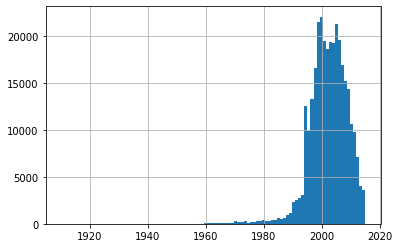

In [21]:
plt.hist(df[(df.RegistrationYear < MAX_YEAR) & (df.RegistrationYear > 1900)].RegistrationYear,
         bins=100
         )

plt.grid()
plt.show()

Судя по распределению имеет смысл выставить минимальный год регистрации 1960 

In [22]:
MIN_YEAR = 1960

Посмотрим на даты регистрации, которые нас на устраивают.

In [23]:
sorted(df[df.RegistrationYear > 2016].RegistrationYear.unique())

[2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Можем разделить их на две категории:
1. Фантастические значения - a-la 3000 - это или ошибки или злостная небрежность
2. Обещания ближайшего будующего - 2017-2019 - вполне может быть, что это возможность сделать предзаказ

Попробуем разобраться

In [24]:
df_near_future = df.query('2016 < RegistrationYear < 2020')
df_near_future.shape

(13551, 15)

Посмотрим на цену

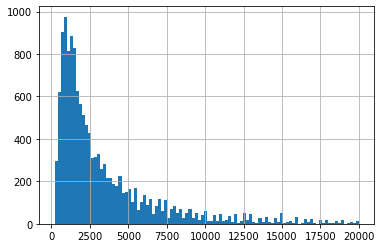

In [25]:
plt.hist(df_near_future.Price,
         bins=100
         )
plt.grid()
plt.show()

Цена ведет себя нормально

Посмотрим на марки

In [26]:
df_near_future.Model.unique()

array(['meriva', 'c4', 'golf', 'punto', 'other', 'astra', 'sportage',
       'twingo', 'zafira', 'corsa', 'i_reihe', 'espace', 'a_klasse',
       'transporter', 'seicento', nan, 'ibiza', '3_reihe', 'e_klasse',
       '3er', '500', 'cooper', 'a3', 'ka', 'passat', 'scenic', 'c_klasse',
       '6_reihe', 'polo', 'civic', 'cr_reihe', 'focus', 'fortwo',
       'sprinter', 'rio', 'ducato', 'a4', 'sharan', 'vectra', 's_klasse',
       'arosa', 'beetle', 'stilo', 'v40', 'c_max', 'kangoo', 'signum',
       'clk', 'mondeo', '2_reihe', '1er', 'c2', 'tt', 'yaris', 'picanto',
       'touran', '601', 'fabia', 'berlingo', 'combo', 'insignia',
       'megane', 'auris', 'logan', 'colt', 'exeo', '80', 'fiesta',
       'c_reihe', 'clio', 'ypsilon', 'getz', 'fusion', 's60', 'accord',
       'leon', 'alhambra', '7er', 'kadett', 'superb', 'micra', 'lupo',
       'fox', 'scirocco', 'almera', 'note', 'primera', 'b_klasse', 'a6',
       'bravo', 'roomster', 'ptcruiser', 'v70', 'tigra', 'c3', 'altea',
       'o

Eсли поизучать вопрос - эти марки есть в годе выпуска 2017-2019

Посмотрим как ведут себя пропуски

In [27]:
df_near_future.isna().mean() * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          99.859789
RegistrationYear      0.000000
Gearbox              11.903181
Power                 0.000000
Model                13.290532
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType             37.820087
Brand                 0.000000
NotRepaired           0.000000
DateCreated           0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Ок, замечательно, у 99% не заполнен тип кузова - это характерно для предзаказов - как правило вы можете его выбрать, как и тип движка и тип коробки. 

Тайна раскрыта!

К сожалению эти данные для нас бесполезны - при предзаказе диллеры дают только нижнюю границу цены и учет этих данных может сдвинуть оценку вниз. 

Избавимся от них

Теперь посмотрим на `фантастические` данные

In [28]:
df_fantastic = df[df.RegistrationYear > 2020]
df_fantastic.shape

(67, 15)

In [29]:
df_fantastic.isna().mean() * 100

DateCrawled            0.000000
Price                  0.000000
VehicleType          100.000000
RegistrationYear       0.000000
Gearbox               71.641791
Power                  0.000000
Model                 37.313433
Kilometer              0.000000
RegistrationMonth      0.000000
FuelType              65.671642
Brand                  0.000000
NotRepaired            0.000000
DateCreated            0.000000
PostalCode             0.000000
LastSeen               0.000000
dtype: float64

Их мало и они плохо заполнены. Избавимся от них тоже.

In [30]:
df.drop(df[df.RegistrationYear > 2016].index, inplace=True)

Посмотрим на качество данных:

In [31]:
df.isna().mean() * 100

DateCrawled          0.000000
Price                0.000000
VehicleType          5.500032
RegistrationYear     0.000000
Gearbox              4.297703
Power                0.000000
Model                4.561863
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             6.818976
Brand                0.000000
NotRepaired          0.000000
DateCreated          0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

По сравнению с начальной картиной стало сильно лучше

#### Пробег

Пробег очень важен для цены, и, кроме того хуже всего предсказывается по другим данным.

Владелец может как держать машину в гараже все время, так и развозить на ней заказы, например.

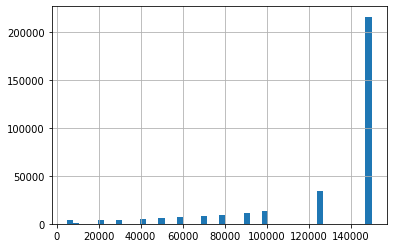

In [32]:
plt.hist(df.Kilometer,
         bins=50
         )
plt.grid()
plt.show()

In [33]:
df.Kilometer.unique()

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000])

Забавно, как дискретизуются значения - очевидно на сайте владельцы выбирали приблизительный пробег из списка, а не вбивали руками.

С данными все в порядке

И это хорошо!

### Дальнейший анализ


Из оставшихся еще не обработанных признаков с припусками нам важны:

- VehicleType
- Gearbox
- FuelType
- Model

Все они связанны друг с другом, и благодаря одним можно попытаться предсказать другие

Необходимо убедится что у нас нет записей, в которых неадекватны все вышеуказанные параметры

In [34]:
mask = ((df.VehicleType.isna()) & (df.Gearbox.isna()) & (df.FuelType.isna()) & (df.Model.isna()))

df[mask]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,yes,2016-03-21,6493,2016-03-24 02:47:34
538,2016-03-15 17:43:21,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,yes,2016-03-15,94315,2016-04-06 14:45:44
1331,2016-04-03 19:53:44,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,yes,2016-04-03,9337,2016-04-05 20:45:24
1345,2016-03-21 01:57:37,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,yes,2016-03-21,85057,2016-03-27 21:44:30
1374,2016-03-28 21:48:01,500,NaN,2000,NaN,0,NaN,5000,0,NaN,mercedes_benz,yes,2016-03-28,59075,2016-04-07 04:44:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352989,2016-03-28 18:42:28,1200,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,yes,2016-03-28,52372,2016-04-04 21:47:08
353104,2016-03-05 23:54:33,1200,NaN,2000,NaN,75,NaN,150000,0,NaN,volkswagen,yes,2016-03-05,86561,2016-03-08 20:48:55
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,yes,2016-03-19,6188,2016-04-01 01:47:17
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,yes,2016-03-07,26789,2016-04-03 11:46:59


Такие данные есть, их немного, уберем их

In [35]:
df.drop(df[mask].index, inplace=True)

Займемся теперь признаками "VehicleType", "Gearbox", "FuelType", "Model"

In [36]:
df[["VehicleType", "Gearbox", "FuelType", "Model"]].isna().mean() * 100

VehicleType    5.185342
Gearbox        3.979008
FuelType       6.508677
Model          4.244047
dtype: float64

In [37]:
df[["VehicleType", "Gearbox", "FuelType", "Model"]].isna().sum(axis=1).value_counts()

0    275940
1     32330
2      9992
3      3954
dtype: int64

Попробуем заполнить пропуски при помощи `CatBoostClassifier` с учетом признаков `VehicleType` и `RegistrationYear`







#### Заполнение `Gearbox` с помощью `CatBoostClassifier`
<a id='question'></a>

Попробуем предсказать коробку по признакам "VehicleType",  "FuelType", "Model", "Brand" "RegistrationYear", - логично предположить что тип коробки передач зависит от типа кузова,  типа топлива, марки и года выпуска

Построим классификатор

Выберм сначала хорошие данные

In [38]:
mask = ((df.VehicleType.notna()) & (df.Gearbox.notna()) & (df.FuelType.notna()) & (df.Model.notna()))

features_name = ["VehicleType", "Gearbox", "FuelType", "Model", "Brand", "RegistrationYear", ]
data = df[mask][features_name]
data.shape

(275940, 6)

In [39]:
target = data['Gearbox']
features = data.drop(columns=['Gearbox', ], axis=1)

features_train, features_valid, target_train, target_valid = (
    train_test_split(
        features, target, test_size=0.2,
        stratify=target,
        shuffle=True,
        random_state=SEED)
)

model_gearbox = CatBoostClassifier(random_seed=SEED,
                                   iterations=300,
                                   custom_loss=['AUC', 'Accuracy'], )

cat_features = ["VehicleType", "FuelType", "Model", "Brand"]

model_gearbox.fit(
    features_train,
    target_train,
    cat_features=cat_features,
    #text_features=text_features,
    eval_set=(features_valid, target_valid),

    verbose=False,
    plot=True
)

print(model_gearbox.is_fitted())
print(model_gearbox.get_params())
print(model_gearbox.get_best_score())

mask_gearbox = df.Gearbox.isna()

data_for_prediction = df[mask_gearbox][["VehicleType", "FuelType", "Model", "Brand", "RegistrationYear", ]].fillna(0)

preds_cgearbox_class = model_gearbox.predict(data_for_prediction)

df.loc[mask_gearbox, "Gearbox"] = preds_cgearbox_class

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

True
{'iterations': 300, 'random_seed': 42, 'custom_loss': ['AUC', 'Accuracy']}
{'learn': {'Accuracy': 0.8585244980792927, 'Logloss': 0.3466751910528088}, 'validation': {'Accuracy': 0.8571790969051243, 'Logloss': 0.35018404672694936, 'AUC': 0.8524939731100789}}


#### Заполнение `Model`, `FuelType`, `VehicleType` с помощью `CatBoostClassifier`


У этих признаков много общего - несколько классов, зависимость дркг оот друга и от признаков "Brand" и "RegistrationYear".

Построим классификатор

Строить его в лоб нет смысла - очевидно у каждого бренда свой набор моделей, с ограниченным выбором `FuelType` и `VehicleType`. 


Разобьем все данные по бренду и внутри каждого бренда будем  строить классификатор

Действия более-менее однотипные, напишем функции

 Для того чтобы корректно разбить данные для мультиклассовой классификации необходимо избавиться от классов, 
 у которых есть только один представитель

In [40]:
def train_test_split_reduced(features, target, **args):
    """
    Это обвертка над функцией `train_test_split` которая выкидывает из трейна классы с одним представителем
    
    :param features: признаки
    :param target: целевой признак
    :param args: все остальные признаки для передачи в функцию train_test_split
    :return: 
    """

    # бьем на трейн и дату

    val_count = target.value_counts()

    # бьем на трейн и дату
    # перед тем как разбить данные, выкидываем оттуда классы, количество представителей которых меньше 2:
    bad_classes = val_count[val_count < 2].index.values

    # print(bad_classes)

    index_of_good_classes = target[~target.isin(bad_classes)].index

    new_target = target.loc[index_of_good_classes]
    new_features = features.loc[index_of_good_classes]

    if "stratify" in args:
        args["stratify"] = new_target

    features_train, features_valid, target_train, target_valid = train_test_split(
        new_features,
        new_target,
        **args)

    return features_train, features_valid, target_train, target_valid

In [41]:
def convert_result_to_tabel(model_result):
    """
    Просто функция для удобного представоения результатов классификации
    
    :model_result: результаты в виде вложенного словаря
    :return: таблица pandas
    """

    new_result = []

    for k, v in model_result.items():
        #print(k)
        result = dict()
        result["brand"] = k
        result["is_fitted"] = v[0]

        try:
            for nk, nv in v[1]["learn"].items():
                result[nk + "_learn"] = nv

            for nk, nv in v[1]["validation"].items():
                result[nk + "_validation"] = nv
        except:
            pass
        new_result.append(result)

    return pd.DataFrame(new_result)

In [42]:
def predict_feature_with_classificators(
        features_name,
        target_name,
        cat_features,
        something_by_brand,
        default_value=None,
        verbose=False
):
    """
    
    Многоклассовый классификатор 
    
    :param features_name: имена признаков
    :param target_name: имена определяемых классов
    :param cat_features: список категориальных переменных
    :param something_by_brand: сводная таблица предскащываемых классов в тренировочной выборке по бренду
    :param verbose: вывод отладочной информации
    :return: 
    """

    brands = set(something_by_brand.index)

    result = dict()

    for brand in brands:

        classification_set = something_by_brand.loc[brand].values[0]

        # если есть пропуски
        if np.nan in classification_set:

            # если кроме nan есть хотя бы пара классов, то строим классификатор: 
            if len(classification_set) > 2:

                # делаем выборку записей без пропусков в фичах и таргете для
                # корректного обучения классификатора
                mask = True
                for item in cat_features + [target_name, ]:
                    mask &= df[item].notna()

                # берем по маске записи внутри одного бренда
                data = df[(df.Brand == brand) & mask][features_name + [target_name, ]]
                #                 print(f"{brand} data shape:", data.shape)

                # бьем на трейн и дату
                target = data[target_name]
                features = data.drop(columns=[target_name, ], axis=1)

                features_train, features_valid, target_train, target_valid = train_test_split_reduced(
                    features,
                    target,
                    test_size=0.2,
                    stratify=target,
                    random_state=SEED
                )

                model = CatBoostClassifier(
                    iterations=100,
                    random_seed=SEED,
                    custom_loss=['AUC', 'Accuracy'],
                )

                model.fit(
                    features_train,
                    target_train,
                    cat_features=cat_features,
                    eval_set=(features_valid, target_valid),
                    verbose=False,
                    plot=verbose
                )

                result[brand] = [model.is_fitted(),
                                 model.get_best_score(),
                                 model.get_best_score(),
                                 ]

                print(f"Classification of  {target_name} for brand {brand} ...  {model.is_fitted()}")

                data_for_prediction = df[(df.Brand == brand) & df[target_name].isna()][features_name].fillna(0)

                # display(data_for_prediction)

                preds_model_class = model.predict(data_for_prediction)

                # display(pd.Series([item[0] for item in preds_model_class]).value_counts())

                if not isinstance(preds_model_class[0], str):
                    df.loc[(df.Brand == brand) & (df[target_name].isna()), target_name] = [item[0] for item in
                                                                                           preds_model_class]
                else:
                    df.loc[(df.Brand == brand) & (df[target_name].isna()), target_name] = preds_model_class

            elif len(classification_set) == 2:
                # если нормальный класс один -- присваиваем его
                local_model_set = classification_set.copy()
                local_model_set.discard(np.nan)

                local_vaiable = next(iter(local_model_set))

                df.loc[(df.Brand == brand) & (df[target_name].isna()), target_name] = local_vaiable

                result[brand] = [True, f"just get single model {local_model}"]
                print(f"Classification of  {target_name} for brand {brand} ...  True")


            else:
                # если класса нет -- собираем свой
                if default_value is None:
                    df.loc[(df.Brand == brand) & (df[target_name].isna()), target_name] = brand + "_other"
                else:
                    df.loc[(df.Brand == brand) & (df[target_name].isna()), target_name] = default_value

                result[brand] = [True, f"just create model {brand}_other"]
                print(f"Classification of {target_name} for brand {brand} ...  True")


        else:
            # do nothing
            pass

    return convert_result_to_tabel(result)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> Молодец, что активно пользуешься функциями👍
</div>

Заполним пропуски в столбце `Model`: 

In [43]:
features_name = ["VehicleType", "Gearbox", "FuelType", "RegistrationYear"]
target_name = "Model"
cat_features = ["VehicleType", "Gearbox", "FuelType"]
default_name = None
fuel_by_brand = pd.pivot_table(df, index=["Brand"], values=target_name, aggfunc=set)

model_result = predict_feature_with_classificators(
    features_name,
    target_name,
    cat_features,
    fuel_by_brand,
    default_name,
)

Classification of  Model for brand rover ...  True
Classification of  Model for brand lancia ...  True
Classification of  Model for brand trabant ...  True
Classification of  Model for brand bmw ...  True
Classification of  Model for brand renault ...  True
Classification of  Model for brand skoda ...  True
Classification of  Model for brand honda ...  True
Classification of  Model for brand fiat ...  True
Classification of  Model for brand mercedes_benz ...  True
Classification of  Model for brand jaguar ...  True
Classification of  Model for brand volvo ...  True
Classification of  Model for brand smart ...  True
Classification of  Model for brand kia ...  True
Classification of  Model for brand chevrolet ...  True
Classification of Model for brand sonstige_autos ...  True
Classification of  Model for brand lada ...  True
Classification of  Model for brand jeep ...  True
Classification of  Model for brand seat ...  True
Classification of  Model for brand audi ...  True
Classification

Посмотрим на метрики:

In [44]:
display(model_result)

,brand,is_fitted,Accuracy_learn,MultiClass_learn,Accuracy_validation,AUC:type=Mu_validation,MultiClass_validation,Logloss_learn,Logloss_validation,AUC_validation
0,rover,True,0.992032,0.035098,0.984127,0.166667,0.048660,NaN,NaN,NaN
1,lancia,True,0.967857,0.157071,0.814286,0.980224,0.479587,NaN,NaN,NaN
2,trabant,True,0.899083,NaN,0.909091,NaN,NaN,0.274671,0.28709,0.932367
3,bmw,True,0.689893,0.715419,0.674081,0.948560,0.761317,NaN,NaN,NaN
4,renault,True,0.622610,0.871238,0.583976,0.948667,0.973515,NaN,NaN,NaN
5,skoda,True,0.760215,0.529718,0.725510,0.979942,0.617097,NaN,NaN,NaN
6,honda,True,0.824672,0.468471,0.757991,0.960700,0.657035,NaN,NaN,NaN
7,fiat,True,0.644452,0.864410,0.579414,0.962955,1.003520,NaN,NaN,NaN
8,mercedes_benz,True,0.621596,0.909846,0.599598,0.979382,0.969828,NaN,NaN,NaN
9,jaguar,True,0.863636,0.357239,0.761364,0.926162,0.573463,NaN,NaN,NaN


Заполненим `FuelType`:

In [45]:
features_name = ["VehicleType", "Gearbox", "Model", "RegistrationYear"]
target_name = "FuelType"
cat_features = ["VehicleType", "Gearbox", "Model"]
fuel_by_brand = pd.pivot_table(df, index=["Brand"], values=target_name, aggfunc=set)
default_name = "gasoline"

result_fuel = predict_feature_with_classificators(
    features_name,
    target_name,
    cat_features,
    fuel_by_brand,
    default_name
)

Classification of  FuelType for brand rover ...  True
Classification of  FuelType for brand lancia ...  True
Classification of  FuelType for brand trabant ...  True
Classification of  FuelType for brand bmw ...  True
Classification of  FuelType for brand renault ...  True
Classification of  FuelType for brand skoda ...  True
Classification of  FuelType for brand honda ...  True
Classification of  FuelType for brand fiat ...  True
Classification of  FuelType for brand mercedes_benz ...  True
Classification of  FuelType for brand jaguar ...  True
Classification of  FuelType for brand volvo ...  True
Classification of  FuelType for brand smart ...  True
Classification of  FuelType for brand kia ...  True
Classification of  FuelType for brand chevrolet ...  True
Classification of  FuelType for brand sonstige_autos ...  True
Classification of  FuelType for brand lada ...  True
Classification of  FuelType for brand jeep ...  True
Classification of  FuelType for brand seat ...  True
Classific

In [46]:
display(result_fuel)

,brand,is_fitted,Accuracy_learn,MultiClass_learn,Accuracy_validation,AUC:type=Mu_validation,MultiClass_validation,Logloss_learn,Logloss_validation,AUC_validation
0,rover,True,0.914591,0.204353,0.887324,0.862477,0.357299,NaN,NaN,NaN
1,lancia,True,0.982699,0.103276,0.904110,0.863465,0.359651,NaN,NaN,NaN
2,trabant,True,0.890830,NaN,0.879310,NaN,NaN,0.307257,0.358664,0.620448
3,bmw,True,0.790560,0.471677,0.781166,0.578063,0.485684,NaN,NaN,NaN
4,renault,True,0.868023,0.329898,0.853458,0.612436,0.361272,NaN,NaN,NaN
5,skoda,True,0.751259,0.535259,0.725352,0.763935,0.607404,NaN,NaN,NaN
6,honda,True,0.936253,0.166829,0.900442,0.887645,0.276706,NaN,NaN,NaN
7,fiat,True,0.902338,0.293149,0.885279,0.549961,0.358927,NaN,NaN,NaN
8,mercedes_benz,True,0.751746,0.548150,0.743911,0.771177,0.569645,NaN,NaN,NaN
9,jaguar,True,0.927171,0.185855,0.888889,0.797267,0.375274,NaN,NaN,NaN


Заполненим `VehicleType`

In [47]:
features_name = ["FuelType", "Gearbox", "Model", "RegistrationYear"]
target_name = "VehicleType"
cat_features = ["FuelType", "Gearbox", "Model"]
default_name = None
vechicle_by_brand = pd.pivot_table(df, index=["Brand"], values=target_name, aggfunc=set)

result_vehicle = predict_feature_with_classificators(
    features_name,
    target_name,
    cat_features,
    vechicle_by_brand,
    default_name,
)

Classification of  VehicleType for brand rover ...  True
Classification of  VehicleType for brand lancia ...  True
Classification of  VehicleType for brand trabant ...  True
Classification of  VehicleType for brand bmw ...  True
Classification of  VehicleType for brand renault ...  True
Classification of  VehicleType for brand skoda ...  True
Classification of  VehicleType for brand honda ...  True
Classification of  VehicleType for brand fiat ...  True
Classification of  VehicleType for brand mercedes_benz ...  True
Classification of  VehicleType for brand jaguar ...  True
Classification of  VehicleType for brand volvo ...  True
Classification of  VehicleType for brand smart ...  True
Classification of  VehicleType for brand kia ...  True
Classification of  VehicleType for brand chevrolet ...  True
Classification of  VehicleType for brand sonstige_autos ...  True
Classification of  VehicleType for brand lada ...  True
Classification of  VehicleType for brand jeep ...  True
Classificat

In [48]:
display(result_vehicle)

,brand,is_fitted,Accuracy_learn,MultiClass_learn,Accuracy_validation,AUC:type=Mu_validation,MultiClass_validation,Logloss_learn,Logloss_validation,AUC_validation
0,rover,True,0.759740,0.626525,0.558442,0.894273,1.067850,NaN,NaN,NaN
1,lancia,True,0.970968,0.167278,0.782051,0.972993,0.578593,NaN,NaN,NaN
2,trabant,True,0.609929,0.994304,0.549296,0.824440,1.239331,NaN,NaN,NaN
3,bmw,True,0.582629,0.946022,0.570933,0.898011,0.972770,NaN,NaN,NaN
4,renault,True,0.807491,0.540805,0.787284,0.938480,0.603623,NaN,NaN,NaN
5,skoda,True,0.726429,0.601140,0.692383,0.974593,0.653428,NaN,NaN,NaN
6,honda,True,0.719455,0.721700,0.672956,0.936175,0.881212,NaN,NaN,NaN
7,fiat,True,0.786531,0.604315,0.779587,0.927772,0.667861,NaN,NaN,NaN
8,mercedes_benz,True,0.696775,0.660172,0.679157,0.968697,0.697052,NaN,NaN,NaN
9,jaguar,True,0.923913,0.202367,0.880435,0.940313,0.348223,NaN,NaN,NaN


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Пропуски успешно заполнены 👍 Модели теперь не будут капризничать)
</div>

#### Коррекция значений Power

При первичном анализе у нас наблюдалось большое количество неадекватных значений мощности.

Посмотрим на гистограмму, предварительно ограничив верхнюю планку значением в 350лс - мощность спорткара

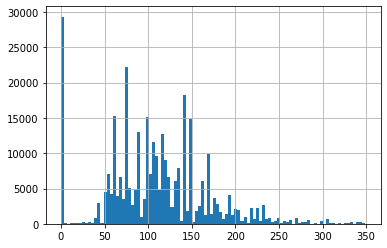

In [49]:
plt.hist(df[df.Power < 350].Power,
         bins=100
         )
plt.grid()
plt.show()

У нас много нулевых значений, которые скорее всего получились из-за того что пользователи не заполнили поле

Посмотрим на квантили:

In [50]:
df[df.Power > 0].Power.quantile(0.05), df[df.Power > 0].Power.quantile(0.95)

(54.0, 224.0)

Порядок квантилей ясен, но не будем брать их как верхнию и нижнюю границы, скорректируем немного значения из следующих соображений:

С учетом того что у нас есть Альфа-Ромео и машины спорткласса остановимся на значении `300` - мы избежим ошибок и супер-каров (с очень специфическим ценообразованием), но оставим себе автобусы

Еще опустим нижнюю границу до `25` - ведь мы оставили машины начиная с `1960` года выпуска

In [51]:
MIN_POWER = 25
MAX_POWER = 300

In [52]:
df[df.Power < MIN_POWER].shape, df[df.Power > 250].shape

((29770, 15), (6995, 15))

Данных слишком много чтобы их отбросить. Заполним средними значениями по категориям `Brand`, `Model` - на мой взгляд это единственные параметры коррелирующие с мощностью движка.

Проверим что данные хорошо кластеризуются по этим параметрам

In [53]:
power_distr_param = pd.pivot_table(
    df[(df.Power > MIN_POWER) & (df.Power < MAX_POWER)],
    index=["Brand", "Model"],
    values="Power",
    aggfunc=["mean", "std", "min", "max"]
)

display(power_distr_param)

display(power_distr_param.describe())

mean        std   min   max
                          Power      Power Power Power
Brand      Model                                      
alfa_romeo 145       112.562500  27.260911    66   227
           147       120.885437  19.835032    76   250
           156       151.211293  23.083927    90   250
           159       172.893939  28.736221   116   260
           other     147.541322  40.951473    50   260
...                         ...        ...   ...   ...
volvo      v40       123.603774  22.778362    85   235
           v50       139.016529  27.357320   109   250
           v60       170.128205  37.176803   114   260
           v70       167.348276  33.651255   103   299
           xc_reihe  184.392157  18.717627   151   286

[297 rows x 4 columns]

,mean,std,min,max
,Power,Power,Power,Power
count,297.000000,295.000000,297.000000,297.000000
mean,125.750160,25.134912,70.225589,213.252525
std,46.200726,13.243373,36.671104,69.612685
min,26.706383,0.000000,26.000000,60.000000
25%,87.858491,15.726897,44.000000,158.000000
50%,123.603774,23.687847,60.000000,228.000000
75%,151.014731,32.263135,90.000000,280.000000
max,296.000000,70.790343,296.000000,299.000000


Дисперсия в разумных пределах, можно аппроксимировать.Но перед этим зададим среднее значение мощности, на случай если мы на найдем аналога

In [54]:
POWER_MEAN = int(df[(df.Power > MIN_POWER) & (df.Power < MAX_POWER)].Power.mean())
POWER_MEAN

118

In [55]:
power_distr = pd.pivot_table(
    df[(df.Power > MIN_POWER) & (df.Power < MAX_POWER)],
    index=["Brand", "Model"],
    values="Power",
    aggfunc="mean",
)

for index in df[(df.Power < MIN_POWER) | (df.Power > MAX_POWER)].index:

    try:
        df.loc[index, "Power"] = int(power_distr.loc[(df.loc[index].Brand, df.loc[index].Model)].values)
    except KeyError:
        print(df.loc[index].Brand, df.loc[index].Model)
        df.loc[index, "Power"] = POWER_MEAN

land_rover serie_1


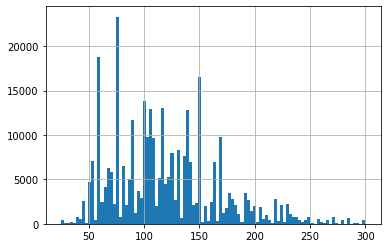

In [56]:
plt.hist(df.Power,
         bins=100
         )
plt.grid()
plt.show()

Характер зависимости не изменился, мы молодцы)

#### Выбор значимых данных


Посмотрим на текущее состояние данных

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322216 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        322216 non-null  datetime64[ns]
 1   Price              322216 non-null  int64         
 2   VehicleType        322216 non-null  object        
 3   RegistrationYear   322216 non-null  int64         
 4   Gearbox            322216 non-null  object        
 5   Power              322216 non-null  int64         
 6   Model              322216 non-null  object        
 7   Kilometer          322216 non-null  int64         
 8   RegistrationMonth  322216 non-null  int64         
 9   FuelType           322216 non-null  object        
 10  Brand              322216 non-null  object        
 11  NotRepaired        322216 non-null  object        
 12  DateCreated        322216 non-null  datetime64[ns]
 13  PostalCode         322216 non-null  int64   

Сделаем предположение, что цена не будет зависеть от параметров

- "DateCrawled", 
- "RegistrationMonth", 
- "DateCreated", 
- "PostalCode", 
- "LastSeen"

Относительно PostalCode я не уверен до конца - возможно приствует зависимость между географией продаж и ценой 

Например аналитики  [авто.ru](https://rg.ru/2019/09/14/nazvany-regiony-s-samymi-deshevymi-poderzhannymi-mashinami.html) утверждают что разница есть. Но с другой стороны это происходит в силу разного модельного ряда продаваемых машин в Москве  и в регионах, и таким образом информация о регионе просто дублирует состояние рынка

Сделаем так - признак `PostalCode` категориальный и немаленький (~8000 значений). Сначала посчитаем без него.


In [58]:
data = df.drop(["DateCrawled", "RegistrationMonth", "DateCreated", "PostalCode", "LastSeen"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322216 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             322216 non-null  int64 
 1   VehicleType       322216 non-null  object
 2   RegistrationYear  322216 non-null  int64 
 3   Gearbox           322216 non-null  object
 4   Power             322216 non-null  int64 
 5   Model             322216 non-null  object
 6   Kilometer         322216 non-null  int64 
 7   FuelType          322216 non-null  object
 8   Brand             322216 non-null  object
 9   NotRepaired       322216 non-null  object
dtypes: int64(4), object(6)
memory usage: 35.1+ MB


### Выводы


- Был провден анализ данных
- Выявленны аномальные и пропущенные значения.
- Даты приведены к соответствующему формату
- Удален не несущий инфрмации столбец `NumberOfPictures`
- Проанализированны и исправленны аномалии в признах `RegistrationYear`,`Power`  
- Удалены значения с некорректным целевым признаком `Price`
- Заполнены пропуски в признеках  `NotRepaired`
- Скорректированны аномальные значения в признаке `Power`
- Пропуски в признаках `VehicleType` `Gearbox` `Model` `FuelType` заполнены при помощи алгоритмов классификации
- Выбран датасет состоящий из важных для таргета признаков

## Обучение моделей

Выберем категориальные данные и разделим данные на обучающую и валидационную выборки.

In [59]:
cat_features = ['VehicleType', 'FuelType', 'Brand', 'Model', 'Gearbox', 'NotRepaired']
num_features = ['RegistrationYear', 'Power', 'Kilometer']


features = data.drop("Price", axis=1)
target = data["Price"]

features_train, features_valid, target_train, target_valid = (
    train_test_split(
        features, target, test_size=0.2,
        random_state=SEED)
)

Проведем масштабирование численных признаков

In [60]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])

In [61]:
features_train.shape, target_train.shape

((257772, 9), (257772,))

Для методов, которым нужны численные признаки проведем кодирование

In [62]:
features.select_dtypes('object').columns

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [63]:
onehotencoder = OneHotEncoder(drop='first', sparse=False).fit(features[cat_features])
feature_names = onehotencoder.get_feature_names(cat_features)

features_train_ohe = pd.concat([features_train[num_features],  
                                pd.DataFrame(onehotencoder.transform(features_train[cat_features]),
                                             columns=feature_names, 
                                             index=features_train.index)], 
                               axis=1)

features_valid_ohe = pd.concat([features_valid[num_features],  
                                pd.DataFrame(onehotencoder.transform(features_valid[cat_features]),
                                             columns=feature_names, 
                                             index=features_valid.index)], 
                               axis=1)


Для моделей, основанных на деревьях решений, будем использовать порядковое кодирование (OrdinalEncoder)

In [64]:
ordinalencoder = OrdinalEncoder(dtype=int).fit(features[cat_features])

features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()

features_train_oe[cat_features] = ordinalencoder.transform(features_train[cat_features])
features_valid_oe[cat_features] = ordinalencoder.transform(features_valid[cat_features])

Сравним

- LinearRegression
- DecisionTreeRegressor

- CatBoostRegressor
- LGBMRegressor

#### LinearRegression

In [65]:
%%time


lr_model = LinearRegression()

lr_result = cross_val_score(lr_model,
                            features_train_ohe,
                            target_train,
                            cv=5,
                            scoring='neg_mean_squared_error').mean()

print('RMSE for LinearRegression: ', (-lr_result) ** 0.5)

RMSE for LinearRegression:  2819.2282967516094
CPU times: user 46.7 s, sys: 7.27 s, total: 54 s
Wall time: 10.6 s


Сразу обучим модель

In [66]:
lr_model.fit(features_train_ohe, target_train)

LinearRegression()

#### DecisionTreeRegressor

In [67]:
%%time

dt_model = DecisionTreeRegressor(criterion='squared_error', random_state=SEED)

dt_param_dist = {'max_features': ['log2', 'sqrt', None],
                 'max_depth': [int(x) for x in np.linspace(start=2, stop=500, num=50)],
                 'splitter': ['best', 'random'],
                 "min_samples_leaf": [int(x) for x in np.linspace(start=20, stop=100, num=10)],
                 "max_leaf_nodes": [int(x) for x in np.linspace(start=20, stop=100, num=10)],
                 }

rs_dt = RandomizedSearchCV(dt_model,
                           dt_param_dist,
                           n_iter=100,
                           cv=4,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           random_state=SEED)

rs_dt.fit(features_train_oe, target_train)

print("Best esimater params: ", rs_dt.best_params_)
print("RMSE for DecisionTreeRegressor:", (-rs_dt.best_score_) ** 0.5)

Best esimater params:  {'splitter': 'best', 'min_samples_leaf': 64, 'max_leaf_nodes': 100, 'max_features': None, 'max_depth': 83}
RMSE for DecisionTreeRegressor: 2225.8543958427445
CPU times: user 793 ms, sys: 550 ms, total: 1.34 s
Wall time: 28.2 s


#### CatBoostRegressor


Для CatBoostRegressor воспользуемся встроенным randomized_search'ем

In [68]:
 parameters = {'depth': [6, 8, 10],
               'learning_rate': [0.01, 0.1, 0.5, 1],
               'iterations': [100, 200, 400]
               }

In [69]:
%%time

cbt_model = CatBoostRegressor(random_seed=SEED, cat_features=cat_features, verbose=False, )

grid = {'learning_rate': [0.01, 0.1, 0.5, 1, 2],
        'iterations': [10, 300],
        'depth': [6, 8, 10],
        }

cbt_randomized_search_result = cbt_model.randomized_search(grid,
                                                           X=features_train,
                                                           y=target_train,
                                                           n_iter=100,
                                                           refit=True,  #сразу обучим модель на лучших данных
                                                           cv=5,
                                                           verbose=False,
                                                           plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 6010.386998
bestIteration = 9


bestTest = 3246.764949
bestIteration = 9


bestTest = 1999.995448
bestIteration = 9


bestTest = 2000.829398
bestIteration = 9



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 6464.607046
bestIteration = 8


bestTest = 2073.609292
bestIteration = 299


bestTest = 1758.637497
bestIteration = 299


bestTest = 1698.72835
bestIteration = 299


bestTest = 1741.374491
bestIteration = 291



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 5201.77992
bestIteration = 299


bestTest = 5999.363615
bestIteration = 9


bestTest = 3173.605431
bestIteration = 9


bestTest = 1932.235885
bestIteration = 9


bestTest = 1928.640853
bestIteration = 9


bestTest = 6377.701299
bestIteration = 9



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 1991.700528
bestIteration = 299


bestTest = 1710.326562
bestIteration = 299


bestTest = 1678.60003
bestIteration = 297


bestTest = 1746.602707
bestIteration = 288



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 3901.08532
bestIteration = 299


bestTest = 5992.318292
bestIteration = 9


bestTest = 3125.311213
bestIteration = 9


bestTest = 1886.393664
bestIteration = 9


bestTest = 1885.303792
bestIteration = 9



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 6234.276719
bestIteration = 9


bestTest = 1926.851974
bestIteration = 299


bestTest = 1673.357006
bestIteration = 299


bestTest = 1658.079418
bestIteration = 286


bestTest = 1740.700979
bestIteration = 151



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 3434.967459
bestIteration = 298

Training on fold [0/5]

bestTest = 1668.85591
bestIteration = 288

Training on fold [1/5]

bestTest = 1622.518781
bestIteration = 296

Training on fold [2/5]

bestTest = 1638.597906
bestIteration = 290

Training on fold [3/5]

bestTest = 1640.35821
bestIteration = 291

Training on fold [4/5]

bestTest = 1670.221724
bestIteration = 289

CPU times: user 26min 13s, sys: 2min 29s, total: 28min 42s
Wall time: 4min 31s


#### LGBMRegressor

In [70]:
features_train_categorical = features_train.copy()

for column in features_train_categorical.columns:
    col_type = features_train_categorical[column].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_train_categorical[column] = features_train_categorical[column].astype('category')

features_valid_categorical = features_valid.copy()

for column in features_valid_categorical.columns:
    col_type = features_valid_categorical[column].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_valid_categorical[column] = features_valid_categorical[column].astype('category')

In [71]:
features_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257772 entries, 212542 to 134079
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       257772 non-null  category
 1   RegistrationYear  257772 non-null  float64 
 2   Gearbox           257772 non-null  category
 3   Power             257772 non-null  float64 
 4   Model             257772 non-null  category
 5   Kilometer         257772 non-null  float64 
 6   FuelType          257772 non-null  category
 7   Brand             257772 non-null  category
 8   NotRepaired       257772 non-null  category
dtypes: category(6), float64(3)
memory usage: 9.6 MB


In [72]:
%%time

lgb_model = LGBMRegressor(random_state=SEED)
lgm_param_dist = {'num_leaves': [10, 50, 100, 200],
                  'learning_rate': [0.01, 0.1, 0.5, 1], }

rs_lgb = RandomizedSearchCV(lgb_model,
                            lgm_param_dist,
                            n_iter=100,
                            cv=4,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error',
                            random_state=SEED)

rs_lgb.fit(features_train_categorical, target_train)

print("Best esimater params: ", rs_lgb.best_params_)
print("RMSE for LGBMRegressor:", (-rs_lgb.best_score_) ** 0.5)

Best esimater params:  {'num_leaves': 200, 'learning_rate': 0.1}
RMSE for LGBMRegressor: 1613.0775772386992
CPU times: user 14.7 s, sys: 7.37 s, total: 22.1 s
Wall time: 18.8 s


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

По модельной части замечаний нет - все сделано четко 💪
</div>

## Анализ моделей


Проверим каждый метод на модели с подобранными ранее гиперпараметрами

In [73]:
from sklearn.metrics import mean_squared_error

#### LinearRegression

In [74]:
%%time

target_predict = lr_model.predict(features_valid_ohe)
lr_result_final = mean_squared_error(target_valid, target_predict)

print('RMSE for LinearRegression: ', lr_result_final ** 0.5)

RMSE for LinearRegression:  2798.249507106296
CPU times: user 169 ms, sys: 180 ms, total: 350 ms
Wall time: 122 ms


#### DecisionTreeRegressor

In [75]:
%%time

dt_model_fin = DecisionTreeRegressor(criterion='squared_error', random_state=SEED, **rs_dt.best_params_)
dt_model_fin.fit(features_train_ohe, target_train)

target_predict = dt_model_fin.predict(features_valid_ohe)
dt_result_final = mean_squared_error(target_valid, target_predict)

print('RMSE for DecisionTreeRegressor: ', dt_result_final ** 0.5)

RMSE for DecisionTreeRegressor:  2228.3466227378153
CPU times: user 3.07 s, sys: 1.02 s, total: 4.09 s
Wall time: 2.55 s


#### CatBoostRegressor

In [76]:
%%time

cbt_model_fin = CatBoostRegressor(**cbt_model.get_params())

cbt_model_fin.fit(features_train, target_train)

target_predict = cbt_model_fin.predict(features_valid)
cbt_result_final = mean_squared_error(target_valid, target_predict)

print('RMSE for CatBoostRegressor: ', cbt_result_final ** 0.5)

RMSE for CatBoostRegressor:  1642.1673085975924
CPU times: user 1min 33s, sys: 2.21 s, total: 1min 35s
Wall time: 16.4 s


#### LGBMRegressor

In [77]:
%%time

lgb_model_fin = LGBMRegressor(criterion='squared_error', random_state=SEED, **rs_lgb.best_params_)
lgb_model_fin.fit(features_train_categorical, target_train)

target_predict = lgb_model_fin.predict(features_valid_categorical)
lgb_result_final = mean_squared_error(target_valid, target_predict)

print('RMSE for CatBoostRegressor: ', lgb_result_final ** 0.5)

RMSE for CatBoostRegressor:  1614.7546168541458
CPU times: user 15.4 s, sys: 7.29 s, total: 22.7 s
Wall time: 5.92 s


## Cравнение моделей

In [78]:
index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']

result_data = [
    {'time': 0.180, 'rmse': lr_result_final ** 0.5},
    {'time': 0.832, 'rmse': dt_result_final ** 0.5},
    {'time': 17.6, 'rmse': cbt_result_final ** 0.5},
    {'time': 7.46, 'rmse': lgb_result_final ** 0.5},
]

result_table = pd.DataFrame(result_data, index=index)
result_table

,time,rmse
LinearRegression,0.180,2798.249507
DecisionTreeRegressor,0.832,2228.346623
CatBoostRegressor,17.600,1642.167309
LGBMRegressor,7.460,1614.754617


Посмотрим на результаты

- Самый быстрый метод - линейная регрессия, что логично)
- Самый точный - LGBMRegressor


Если смотреть в общем, то наилучшие результаты с точки зрения точности достигаются у `CatBoostRegressor` и `LGBMRegressor`, но 
по скорости `LGBMRegressor` существенно выигрывает у `CatBoostRegressor`

`LinearRegression` и `DecisionTreeRegressor` работают очень быстро, но дают существенно менее точные результаты 

## Вывод


В ходе работы были проанализированны данные и проведена их предобработка. Для заполнения пропусков использовались как щаполнение средним по категории, так и `CatBoostClassifier`

Для каждого использукмого метода проведена процедура подбора оптимальных гиперпараметров. 
Проведено сравнени методов по точности и времени выполнения с найденным набором гиперпараметров.